# Setting folder

In [1]:
%pwd

'/workspace/source'

# Import

In [2]:
import os
import time

from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# import albumentations as A
# import albumentations.pytorch as Ap

from torchvision import transforms
import torchvision.models as models

from utils import load_all_set

## seed value

In [3]:
IN_HEIGHT, IN_WIDTH = 224, 224

RESOURCE = "GPU"

RANDOM_SEED = 46

EPOCH = 100
BATCH_SIZE =  64
lr = 1e-3
EARLY_STOP = 20

"""
model name
-resnet50
-resnet50_pretrained
-vgg19
-vgg19_pretrained
"""
model_name = 'vgg16'

dir_name = f'result/{model_name}'

if not os.path.exists(dir_name):
    os.mkdir(dir_name)

model_path = f'{dir_name}/{model_name}.pth'
acc_path = f'{dir_name}/acc.png'
loss_path = f'{dir_name}/loss.png'
cm_path = f'{dir_name}/confusion_matrix.png'

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if RESOURCE == "CPU":
    device = torch.device("cpu")
    torch.manual_seed(RANDOM_SEED)
elif RESOURCE == "GPU":
    device = torch.device("cuda")
    torch.cuda.manual_seed(RANDOM_SEED)

# Install dataset

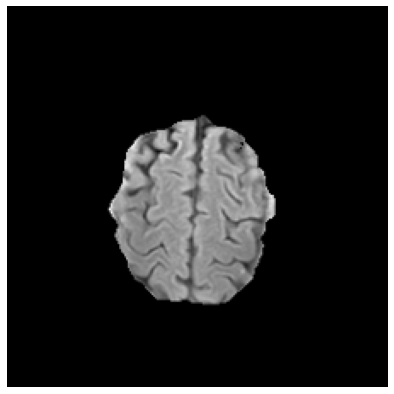

In [4]:
x_train, y_train, x_val, y_val, x_test, y_test = load_all_set()

plt.figure(figsize=(7,7))
plt.axis('off')
plt.imshow(x_train[0], cmap='gray')

In [5]:
class MyDataset(Dataset):
    def __init__(self, xs, ys, transforms=None):
        self.xs = xs
        self.ys = ys
        self.transforms = transforms
        self.data_num = len(xs)

    def __len__(self):
        return self.data_num

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]

        if self.transforms:
            x = self.transforms(x)
        
        return x, y

In [6]:
transforms_train = transforms.Compose([
    transforms.ToTensor(),
])

transforms_val = transforms.Compose([
    transforms.ToTensor(),
])

In [7]:
dataset_train = MyDataset(xs=x_train, ys=y_train, transforms=transforms_train)
dataset_val = MyDataset(xs=x_val, ys=y_val, transforms=transforms_val)

train_n = len(dataset_train)
val_n = len(dataset_val)

print(train_n)
print(val_n)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=True)

8980
1448


# Model compile

In [8]:
model = models.vgg16(pretrained=False)
model.features[0] = nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=1)
model.classifier[6] = nn.Sequential(nn.Linear(4096,1, bias=True), nn.Sigmoid())

model = model.to(device)
criterion = nn.BCELoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=lr)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Train

In [9]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

min_train_acc = 0
min_train_loss = 0
min_val_acc = 0
min_val_loss = val_n
stop_count = 0

for epoch in range(EPOCH):
    model.train()

    tr_loss = 0
    correct = 0
    total = 0

    # Training
    train_time_start = time.time()

    step = 0
    batch_accuracy = 0
    for inputs, targets in tqdm(dataloader_train):
        optimizer.zero_grad()

        n_batch = len(inputs)

        inputs = inputs.to(device)
        targets = targets.to(torch.float32)
        targets = targets.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, targets)

        loss = loss / n_batch
        loss.backward()

        optimizer.step()
        
        b_outputs = outputs.squeeze().cpu().detach().numpy().copy()
        b_targets = targets.squeeze().cpu().detach().numpy().copy()
        b_outputs = np.where(b_outputs>0.5, 1.0, 0.0)
        batch_accuracy += accuracy_score(b_targets, b_outputs)
        step += 1

    train_time_end = time.time()

    model.eval()

    # train data accuracy and loss 
    step = 0
    batch_accuracy = 0
    train_loss = 0
    with torch.no_grad():
        for train_inputs, train_targets in dataloader_train:
            
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(torch.float32)
            train_targets = train_targets.to(device)
            
            train_outputs = model(train_inputs)

            loss = criterion(train_outputs, train_targets)

            train_loss += loss.item() / train_n

            b_outputs = train_outputs.squeeze().cpu().numpy().copy()
            b_targets = train_targets.squeeze().cpu().numpy().copy()
            b_outputs = np.where(b_outputs>0.5, 1.0, 0.0)
            batch_accuracy += accuracy_score(b_targets, b_outputs)
            step += 1

    train_accuracy = batch_accuracy / step
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Validation data accuracy and loss
    val_time_start = time.time()

    step = 0
    batch_accuracy = 0
    val_loss = 0
    with torch.no_grad():
        for val_inputs, val_targets in dataloader_val:
            
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(torch.float32)
            val_targets = val_targets.to(device)
            
            val_outputs = model(val_inputs)

            loss = criterion(val_outputs, val_targets)

            val_loss += loss.item() / val_n

            b_outputs = val_outputs.squeeze().cpu().numpy().copy()
            b_targets = val_targets.squeeze().cpu().numpy().copy()
            b_outputs = np.where(b_outputs>0.5, 1.0, 0.0)
            batch_accuracy += accuracy_score(b_targets, b_outputs)
            step += 1

    val_accuracy = batch_accuracy / step
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)

    val_time_end = time.time()

    # --- Early stopping ---
    if min_val_loss > val_loss:
        torch.save(model.state_dict(), model_path)
        epoch_min_val_loss = epoch + 1
        min_val_loss = val_loss
        min_train_acc = train_accuracy
        min_train_loss = train_loss
        min_val_acc = val_accuracy
        stop_count = 0
    else:
        stop_count += 1
    
    if stop_count == EARLY_STOP:
        print('Early Stopping!!')
        print(f"epoch:{epoch_min_val_loss}/{EPOCH} [train]loss{min_train_loss:.6f} acc:{min_train_acc:.4f}, [val]loss:{min_val_loss:.6f}, acc:{min_val_acc:.4f}")
        break
    # --- finish ---
    
    train_time = train_time_end - train_time_start
    val_time = val_time_end - val_time_start
    total_time = train_time + val_time

    print(f"epoch:{epoch+1}/{EPOCH} [train]loss{train_loss:.6f} acc:{train_accuracy:.4f}, [val]loss:{val_loss:.6f}, acc:{val_accuracy:.4f}")

    if (epoch+1) % 5 == 0:
        plt.figure(facecolor="azure", figsize=(10,7))
        plt.grid()
        plt.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
        plt.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
        plt.legend(loc="upper right")
        plt.xlabel(xlabel="Epoch")
        plt.ylabel(ylabel="Loss")
        plt.show()
        
        plt.figure(facecolor="azure", figsize=(10,7))
        plt.grid()
        plt.plot(train_accuracies, marker=".", markersize=6, color="red", label="train accuracy")
        plt.plot(val_accuracies, marker=".", markersize=6, color="blue", label="val accuracy")
        plt.legend(loc="upper right")
        plt.xlabel(xlabel="Epoch")
        plt.ylabel(ylabel="Accuracy")
        plt.show()

print("Training finish")
print(f"epoch:{epoch_min_val_loss} [train]loss{min_train_loss:.6f} acc:{min_train_acc:.4f}, [val]loss:{min_val_loss:.6f}, acc:{min_val_acc:.4f}")
plt.figure(facecolor="azure", figsize=(10,7))
plt.grid()
plt.plot(train_accuracies, marker=".", markersize=6, color="red", label="train accuracy")
plt.plot(val_accuracies, marker=".", markersize=6, color="blue", label="val accuracy")
plt.legend(loc="upper right")
plt.xlabel(xlabel="Epoch")
plt.ylabel(ylabel="Accuracy")
plt.savefig(acc_path)
plt.close()

plt.figure(facecolor="azure", figsize=(10,7))
plt.grid()
plt.plot(train_losses, marker=".", markersize=6, color="red", label="train loss")
plt.plot(val_losses, marker=".", markersize=6, color="blue", label="val loss")
plt.legend(loc="upper right")
plt.xlabel(xlabel="Epoch")
plt.ylabel(ylabel="Loss")
plt.savefig(loss_path)
plt.close()


  0%|          | 0/141 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 10.76 GiB total capacity; 6.74 GiB already allocated; 78.56 MiB free; 6.95 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Test

2458
85.98%


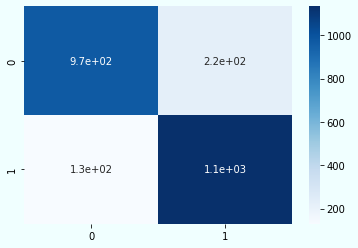

In [ ]:
transforms_test = transforms.Compose([
    transforms.ToTensor(),
])
dataset_test = MyDataset(xs=x_test, ys=y_test, transforms=transforms_test)

test_n = len(dataset_test)
print(test_n)

dataloader_test = DataLoader(dataset_test, batch_size=2*BATCH_SIZE)

model.load_state_dict(torch.load(model_path))
model.eval()

step = 0
batch_accuracy = 0
y_pred = []
with torch.no_grad():
    for inputs, targets in dataloader_test:
        n_batch = len(inputs)

        inputs = inputs.to(device)
        targets = targets.to(torch.float32)
        targets = targets.to(device)
        
        outputs = model(inputs)
        
        b_outputs = outputs.squeeze().cpu().numpy().copy()
        b_targets = targets.squeeze().cpu().numpy().copy()
        b_outputs = np.where(b_outputs>0.5, 1.0, 0.0)

        for i in b_outputs:
            y_pred.append([i])

        batch_accuracy += accuracy_score(b_targets, b_outputs)
        step += 1

test_accuracy = batch_accuracy / step
y_pred = np.array(y_pred)

print(f'{100*test_accuracy:.2f}%')

cm = confusion_matrix(y_test, y_pred)
plt.figure(facecolor="azure")
sns.heatmap(cm, annot=True, cmap='Blues')
plt.savefig(cm_path)